In [1]:
!python3 --version
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, Aer, execute
from qiskit.algorithms.optimizers import TNC, CG
from qiskit.opflow import X, Y, Z, I, PauliSumOp, PauliOp

Python 3.6.8


The Fauseweh-Zhu paper [here](https://arxiv.org/pdf/2112.04276).

Optimization library in
- [Julia](https://julianlsolvers.github.io/Optim.jl/stable/algo/linesearch/)
- [Python](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) (BFGS)

- [TrotterQRTE](https://docs.quantum.ibm.com/api/qiskit/0.46/qiskit.algorithms.time_evolvers.trotterization.TrotterQRTE) for time evolution
- Using [estimator](https://docs.quantum.ibm.com/api/qiskit/0.46/qiskit.primitives.Estimator) to measure expectation

Optimise by (if not deprecated):
- [Conjugate gradient](https://docs.quantum.ibm.com/api/qiskit/0.26/qiskit.algorithms.optimizers.CG)
- [Truncated descent](https://docs.quantum.ibm.com/api/qiskit/0.26/qiskit.algorithms.optimizers.CG)

In [2]:
chain_length = 4

num_layers = 1

shots = 2000

In [3]:
parameter_space_size = 2 * chain_length + 3 * chain_length * num_layers

param_space = [0]*parameter_space_size

In [12]:
def ansatz_circuit_0(qc, param_space):
    # layer 0
    param_counter = 0
    for i in range(chain_length):
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    
def ansatz_circuit_1(qc, param_space):
    param_counter = 2 * chain_length
    for i in range(chain_length-1):
        qc.cx(i,i+1)
    qc.cx(-1,0)
    for i in range(chain_length):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
        qc.rz(param_space[param_counter],i)

def create_ansatz_circuit(qc, num_layers=num_layers, param_space=param_space):
    ansatz_circuit_0(qc, param_space)
    for i in range(num_layers):
        ansatz_circuit_1(qc, param_space)

def ansatz_circuit_ladder(qc, param_space):
    register_size = chain_length*2
    # layer 0
    param_counter = 0
    for i in range(register_size):
        qc.rx(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(register_size):
        qc.rz(param_space[param_counter],i)
        param_counter=param_counter+1
    for i in range(1,register_size//2):
        place = 2 * i - 1
        qc.cx(place,place+1)
    # qc.cx(-1,0)

def simulate(qc, shots=shots):
    ## Run this cell to simulate 'qpe4' and to plot the histogram of the result
    sim = Aer.get_backend('aer_simulator')
    count_qpe4 = execute(qc, sim, shots=shots).result().get_counts()
    # return plot_histogram(count_qpe4)#, figsize=(9,5))
    return count_qpe4

def hamiltonian(t, J=1, A=2, Ω=1):
    creator = ['I']*chain_length
    paulis = ['I','X','Y','Z']
    ham = [] # [('X',1.0)]
    for i in range(chain_length-1):
        for j in range(1,4):
            op = creator[:]
            op[i] = paulis[j]
            op[i+1] = paulis[j]
            ham.append((''.join(op), -J/4))
    for i in range(
    print(ham)

In [13]:
hamiltonian(0)

[('XXII', -0.25), ('YYII', -0.25), ('ZZII', -0.25), ('IXXI', -0.25), ('IYYI', -0.25), ('IZZI', -0.25), ('IIXX', -0.25), ('IIYY', -0.25), ('IIZZ', -0.25)]


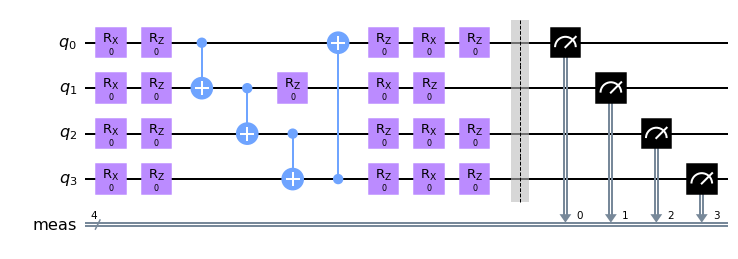

In [5]:
qc = QuantumCircuit(chain_length)

# qc.h(qc.qubits)

create_ansatz_circuit(qc)

qc.measure_all()

qc.draw('mpl')

CPU times: user 163 ms, sys: 8.09 ms, total: 172 ms
Wall time: 172 ms


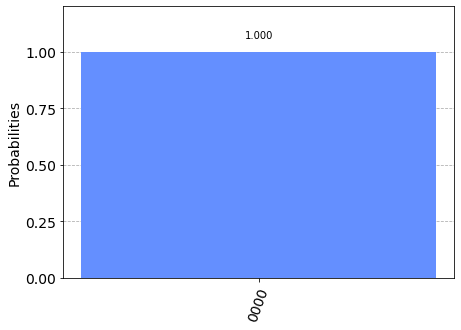

In [6]:
%%time
plot_histogram(simulate(qc))